## Loading Data and Calculating Speed

In [20]:
import numpy as np
import pandas as pd
import math
import random
MAIN_PATH = '/kaggle/input/indian-driving-dataset-primary-obd/idd_mm_primary/idd_multimodal/primary/d0/'
train_data = pd.read_csv(MAIN_PATH+'train.csv')

timestamps = train_data.iloc[:, 0].values
image_ids = train_data.iloc[:, 1]
space = train_data.iloc[:, 2:].values
#following code was previously for loading obd data, but not used
#obd = pd.read_csv('/kaggle/input/indian-driving-dataset-primary-obd/idd_mm_primary/idd_multimodal/supplement/obd/d0/obd.csv')
#spd_time = obd.iloc[:, 0].values
#speeds = obd.iloc[:, 1].values

> Speed smoothing using Exponential Moving Average

In [21]:
def calc(A, B):
    lat1_rad = math.radians(A[0])
    lon1_rad = math.radians(A[1])
    lat2_rad = math.radians(B[0])
    lon2_rad = math.radians(B[1])
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    a = math.sin(delta_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    R = 6371000
    d_h = R * c
    delta_h = A[2] - B[2]
    return math.sqrt(d_h ** 2 + delta_h ** 2)
def exponential_moving_average(new_value, alpha, previous_ema):
    return alpha * new_value + (1 - alpha) * previous_ema

times = []
for i in timestamps:
    parts = i.split('-')
    s = int(parts[0])*3600 + int(parts[1])*60 + int(parts[2]) + int(parts[3])/1000000
    times.append(s)
pointA = space[0]
timeA = times[0]
alpha = 0.2
ema = None
smoothed_speeds = []

for i in range(1, len(image_ids)):
    pointB = space[i]
    timeB = times[i]
    dist = calc(pointA, pointB)
    time_diff = timeB - timeA
    if time_diff > 0:
        FSPD = dist / time_diff
        if ema is None:
            ema = FSPD
        else:
            ema = exponential_moving_average(FSPD, alpha, ema)
        smoothed_speeds.append(ema)
        pointA = pointB
        timeA = timeB

for i in range(200, 211):
    if i < len(smoothed_speeds):
        print(i, 'm/s=%.2f' % smoothed_speeds[i], ', km/h=%.2f' % (smoothed_speeds[i] * 3.6))
print("Values in dataset:", len(smoothed_speeds))

200 m/s=5.74 , km/h=20.67
201 m/s=6.42 , km/h=23.10
202 m/s=5.98 , km/h=21.53
203 m/s=5.71 , km/h=20.56
204 m/s=6.48 , km/h=23.34
205 m/s=6.16 , km/h=22.17
206 m/s=5.86 , km/h=21.10
207 m/s=6.46 , km/h=23.25
208 m/s=6.12 , km/h=22.02
209 m/s=5.81 , km/h=20.91
210 m/s=6.67 , km/h=24.01
Values in dataset: 2210


## Importing required libraries and models

In [ ]:
import tensorflow as tf
from keras.preprocessing import image
!pip install ultralytics
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

> Loading the Model and making Height Dictionary

In [19]:
model = YOLO("yolov8s.pt")
heights={   #dictionary to store heights of common classes in metres
    0: 1.7, #person
    1: 1.2, #cycle
    2: 1.5, #car
    3: 1.2, #motorcycle
    5: 3.5, #bus
    7: 3.75, #truck
    15: 0.25, #cat
    16: 0.5, #dog
    17: 1.5, #horse
    19: 1.3 #cow
}

## Random Single Evaluation of All Model Functions 

13
[     209.62      193.49      253.01      291.04] person 0.8171846
[     72.811      255.34      112.59      315.04] motorcycle 0.7394627
[     248.57      189.18      278.72      245.08] person 0.7141511
[     86.364       199.8      130.22      302.34] person 0.68676454
[     213.77      247.69       250.9      315.29] motorcycle 0.6730463
[     248.92      209.24      300.34      253.99] motorcycle 0.65009725
[     301.11      185.74      314.66      196.09] car 0.45196775
[     59.036      205.86      130.96      301.01] person 0.44704786
[     424.99      192.82      435.55      226.02] person 0.39492825
[     283.97       183.4      297.23       192.2] car 0.38510293
[     58.995      205.14      102.37      301.22] person 0.3197252
[     433.24       202.9      483.29      231.58] bicycle 0.3027374
[     319.31      189.23      339.71      205.06] car 0.2907877


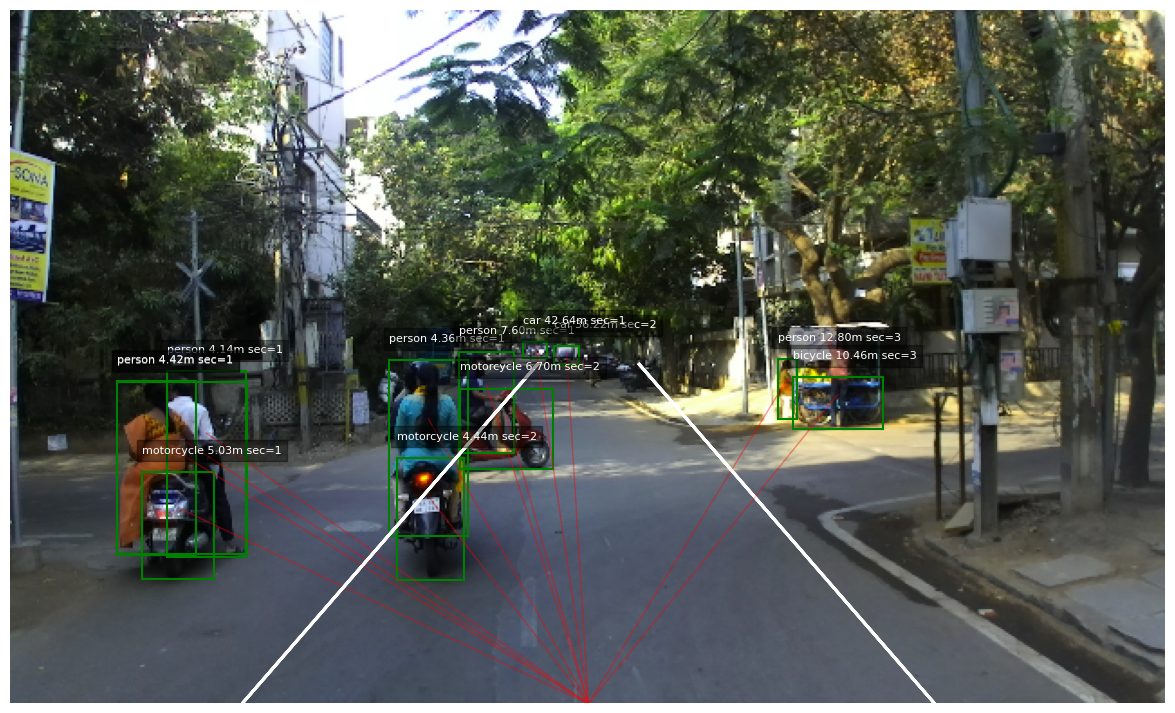

FSPD:4.410 m/s CLDT:4.438 m TTC:1.006 s
TTC Above Threshold: 1776


In [18]:
import os
os.makedirs('test', exist_ok=True)

index = random.randint(0, len(image_ids))
path = (str(index).rjust(7, '0'))+'.jpg'
image_path = MAIN_PATH+'leftCamImgs/'+path
test_image = image.load_img(image_path, target_size=(384, 640))
detections = model.predict(test_image)
print(len(detections[0].boxes))
fig, ax = plt.subplots(1, figsize=(15,9))
ax.imshow(test_image)
plt.axis('off')
plt.savefig('test/input.jpg', bbox_inches='tight')

f = 250  # Focal length in pixels
image_height = 384
image_width = 640
top_val = 0.456
bottom_val = 0.2
y_offset = 0.51
#guide lines for road detection
f1 = plt.Line2D((top_val*image_width, bottom_val*image_width), (image_height*y_offset, image_height), color='w', linewidth=2, alpha=0.6)
f2 = plt.Line2D(((1-top_val)*image_width, (1-bottom_val)*image_width), (image_height*y_offset, image_height), color='w', linewidth=2, alpha=0.6)
m1 = (image_height/2)/(top_val*image_width - bottom_val*image_width)
m2 = -m1

def section(x1, y1):
    s=''
    if -192 * x1 - 163.84 * y1 + 87490.56 < 0:
        s+= '1R'
    else:
        s+= '1L'
    if -192 * x1 + 163.84 * y1 + 35389.44 > 0:
        s+= '2L'
    else:
        s+= '2R'
    if s=='1L2L':
        return 1
    elif s=='1R2L':
        return 2
    elif s=='1R2R':
        return 3
    else:
        return 4

closest_distance = 200
for detection in detections[0].boxes:
    box = detection.xyxy[0].cpu().numpy()  # Get the bounding box coordinates and transfer to CPU
    class_id = int(detection.cls[0].cpu().numpy())  # Get the class ID and transfer to CPU
    confidence = detection.conf[0].cpu().numpy()  # Get the confidence score and transfer to CPU
    
    print(box, model.names[class_id], confidence)
    if confidence < 0.3:
        continue

    x1, y1, x2, y2 = box
    
    bbox_height = y2 - y1
    if bbox_height > 0:  # To avoid division by zero
        H = heights.get(class_id, 1.5)
        distance = H * f / bbox_height
    # bounding boxes
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    
    #line from the bottom of the image to the bounding box
    line_x = x1 + (x2 - x1) / 2
    line = plt.Line2D((line_x, image_width/2), (y1+bbox_height/3, image_height), linewidth = 1, color='r', alpha=0.4)
    ax.add_line(line)
    
    #guide lines for road detection
    ax.add_line(f1)
    ax.add_line(f2)
    #section detection
    sec = section(line_x, y1+bbox_height/3)
    if distance<closest_distance and sec==2: #distance based on sec
        closest_distance=distance
    
    # class label, confidence score, and distance
    label = f'{model.names[class_id]} {distance:.2f}m sec={sec}'
    plt.text(x1, y1 - 10, label, color='w', fontsize=8, bbox=dict(facecolor='black', alpha=0.4))

plt.savefig('help.jpg', bbox_inches='tight')
plt.show()
plt.close()
TTC = closest_distance/smoothed_speeds[index]
print("FSPD:%.3f m/s"%smoothed_speeds[index], "CLDT:%.3f m"%closest_distance, "TTC:%.3f s"%TTC)
if TTC<0.65:
    print("WARNING: TTC Below Threshold:", index)
else:
    print("TTC Above Threshold:", index)

## Evaluating Model on All Images

In [ ]:
import time
from copy import copy

negatives = 0
positives = 0
f = 250  # Focal length in pixels
image_height = 384
image_width = 640
top_val = 0.456
bottom_val = 0.2
y_offset = 0.51

# Guide lines for road detection
f1 = plt.Line2D((top_val * image_width, bottom_val * image_width), (image_height * y_offset, image_height), color='w', linewidth=2, alpha=0.6)
f2 = plt.Line2D(((1 - top_val) * image_width, (1 - bottom_val) * image_width), (image_height * y_offset, image_height), color='w', linewidth=2, alpha=0.6)
m1 = (image_height / 2) / (top_val * image_width - bottom_val * image_width)
m2 = -m1

for index in range(len(smoothed_speeds)):
    closest_distance = 200
    path = (str(index).rjust(7, '0')) + '.jpg'
    image_path = MAIN_PATH+'leftCamImgs/' + path
    test_image = image.load_img(image_path, target_size=(384, 640))
    detections = model.predict(test_image, verbose=False)
    print(f"Progress: {index}", end='\r')

    for detection in detections[0].boxes:
        box = detection.xyxy[0].cpu().numpy()  # Get the bounding box coordinates and transfer to CPU
        class_id = int(detection.cls[0].cpu().numpy())  # Get the class ID and transfer to CPU
        confidence = detection.conf[0].cpu().numpy()  # Get the confidence score and transfer to CPU

        if confidence < 0.3:
            continue

        x1, y1, x2, y2 = box

        bbox_height = y2 - y1
        if bbox_height > 0:  # To avoid division by zero
            H = heights.get(class_id, 1.5)  # Taking 1.5 if not in dictionary
            distance = H * f / bbox_height

        # Section detection
        sec = section(x1 + (x2 - x1) / 2, y1 + bbox_height / 3)

        if distance < closest_distance and sec == 2:  # Distance based on sec
            closest_distance = distance
            closest_box = box
            closest_class_id = class_id
            closest_confidence = confidence

    TTC = closest_distance / smoothed_speeds[index]
    if TTC < 0.65:
        fig, ax = plt.subplots(1, figsize=(15, 9))
        ax.imshow(test_image)
        x1, y1, x2, y2 = closest_box
        print(closest_box, model.names[closest_class_id], closest_confidence)

        # Bounding boxes
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5, edgecolor='r', facecolor='red', alpha=0.15)
        flash = patches.Rectangle((0, 0), image_width, image_height, linewidth=10, edgecolor='r', facecolor='red', alpha=0.2)
        ax.add_patch(rect)
        ax.add_patch(flash)

        # Line from the bottom of the image to the bounding box
        line_x = x1 + (x2 - x1) / 2
        line = plt.Line2D((line_x, image_width/2), (y1+bbox_height/3, image_height), linewidth = 1, color='r', alpha=0.4)
        ax.add_line(line)

        f1_c = copy(f1)
        f2_c = copy(f2)
        # Guide lines for road detection
        ax.add_line(f1_c)
        ax.add_line(f2_c)

        # Class label, confidence score, and distance
        label = f'{model.names[closest_class_id]} {closest_distance:.2f}m sec={sec}'
        plt.text(x1, y1 - 10, label, color='w', fontsize=8, bbox=dict(facecolor='black', alpha=0.4))
        plt.axis('off')
        plt.show()
        plt.close()

        print("FSPD:%.3f m/s" % smoothed_speeds[index], "CLDT:%.3f m" % closest_distance, "TTC:%.3f s" % TTC)
        print("WARNING: TTC Below Threshold: ", index)
        print("Cut-In Detected!")
        positives += 1
    else:
        negatives += 1

print("Evaluation Ended.")
print("Frames Above Threshold:", negatives)
print("Cut in frames detected:", positives)

## Limited Run to Save Output Images

import time
from copy import copy
import os
os.makedirs('input', exist_ok=True)
os.makedirs('output', exist_ok=True)

negatives = 0
positives = 0
f = 250  # Focal length in pixels
image_height = 384
image_width = 640
top_val = 0.456
bottom_val = 0.2
y_offset = 0.51

# Guide lines for road detection
f1 = plt.Line2D((top_val * image_width, bottom_val * image_width), (image_height * y_offset, image_height), color='w', linewidth=2, alpha=0.6)
f2 = plt.Line2D(((1 - top_val) * image_width, (1 - bottom_val) * image_width), (image_height * y_offset, image_height), color='w', linewidth=2, alpha=0.6)
m1 = (image_height / 2) / (top_val * image_width - bottom_val * image_width)
m2 = -m1

for index in range(300, 600):
    closest_distance = 200
    valid_distance = 200
    path = (str(index).rjust(7, '0')) + '.jpg'
    image_path = MAIN_PATH+'leftCamImgs/' + path
    test_image = image.load_img(image_path, target_size=(384, 640))
    detections = model.predict(test_image, verbose=False)
    print(f"Progress: {index}", end='\r')

    for detection in detections[0].boxes:
        box = detection.xyxy[0].cpu().numpy()  # Get the bounding box coordinates and transfer to CPU
        class_id = int(detection.cls[0].cpu().numpy())  # Get the class ID and transfer to CPU
        confidence = detection.conf[0].cpu().numpy()  # Get the confidence score and transfer to CPU

        if confidence < 0.3:
            continue

        x1, y1, x2, y2 = box

        bbox_height = y2 - y1
        if bbox_height > 0:  # To avoid division by zero
            H = heights.get(class_id, 1.5)  # Taking 1.5 if not in dictionary
            distance = H * f / bbox_height

        # Section detection
        sec = section(x1 + (x2 - x1) / 2, y1 + bbox_height / 3)

        if distance < valid_distance:
            valid_distance = distance
            valid_box = box
            valid_class_id = class_id
            valid_confidence = confidence
            valid_sec = sec
        if distance < closest_distance and sec == 2:  # Distance based on sec
            closest_distance = distance
            closest_box = box
            closest_class_id = class_id
            closest_confidence = confidence

    TTC = closest_distance / smoothed_speeds[index]
    if True: #save all images
        fig, ax = plt.subplots(1, figsize=(15, 9))
        ax.imshow(test_image)
        plt.axis('off')
        plt.savefig('input/'+path, bbox_inches='tight')
        
        x1, y1, x2, y2 = closest_box
        vx1, vy1, vx2, vy2 = valid_box
        print(closest_box, model.names[closest_class_id], closest_confidence)

        # Bounding boxes
        if closest_distance != 200:
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5, edgecolor='r', facecolor='red', alpha=0.15)
        else:
            rect = patches.Rectangle((vx1, vy1), vx2 - vx1, vy2 - vy1, linewidth=1.5, edgecolor='g', facecolor='green', alpha=0.15)
        ax.add_patch(rect)

        # Line from the bottom of the image to the bounding box
        if closest_distance !=200:
            line_x = x1 + (x2 - x1) / 2
            line = plt.Line2D((line_x, image_width/2), (y1+bbox_height/3, image_height), linewidth = 1, color='r', alpha=0.4)
        else:
            line_x = vx1 + (vx2 - vx1) / 2
            line = plt.Line2D((line_x, image_width/2), (vy1+bbox_height/3, image_height), linewidth = 1, color='r', alpha=0.4)
        ax.add_line(line)

        f1_c = copy(f1)
        f2_c = copy(f2)
        # Guide lines for road detection
        ax.add_line(f1_c)
        ax.add_line(f2_c)

        # Class label, confidence score, and distance
        if closest_distance!=200:
            label = f'{model.names[closest_class_id]} {closest_distance:.2f}m sec={sec}'
            plt.text(x1, y1 - 10, label, color='w', fontsize=8, bbox=dict(facecolor='black', alpha=0.4))
        else:
            label = f'{model.names[valid_class_id]} {valid_distance:.2f}m sec={valid_sec}'
            plt.text(vx1, vy1 - 10, label, color='w', fontsize=8, bbox=dict(facecolor='black', alpha=0.4))
        
        plt.savefig('output/'+path, bbox_inches='tight')
        plt.close()

        print('Saving Image:', index, end='\r')
        positives += 1
    else:
        negatives += 1

print("Saving Finished.")

TO DOWNLOAD WHOLE CODE: 
!zip -r file.zip /kaggle/working